In [1]:
# ==========================================
# 1. SETUP & IMPORT LIBRARY
# ==========================================
import os
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix

# --- KHUSUS GOOGLE COLAB: MOUNT DRIVE ---
#from google.colab import drive
#try:
#    drive.mount('/content/drive')
#except ImportError:
#    print('Google Colab not detected. Skipping mount.')

# --- KONFIGURASI PATH (SESUAIKAN DENGAN GOOGLE DRIVE) ---
DATASET_DIR = '/content/drive/MyDrive/intermediate'
if not os.path.exists(DATASET_DIR):
    # Fallback to local path if drive not mounted
    DATASET_DIR = os.path.join(os.getcwd(), 'dataset')
OUTPUT_DIR = os.path.join(os.getcwd(), 'ready_for_fusion')
FEATURE_DIR = os.path.join(os.getcwd(), 'Extracted_Feature')


# --- HYPERPARAMETERS ---
CONFIG = {
    'target_dim': 256,       # Dimensi output embedding (Common Space)
    'dropout': 0.3,
    'use_layer_norm': True,
    'save_dir': OUTPUT_DIR,
    'lr': 1e-3,
    'weight_decay': 5e-5,
    'batch_size': 32,
    'attn_dim': 64,
    'num_heads': 4,
    'patience': 20,
    'epochs': 100
}

# Buat folder output jika belum ada
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print(f"Dataset Path: {DATASET_DIR}")
print(f"Output Path: {OUTPUT_DIR}")
print(f"Feature Path: {FEATURE_DIR}")
print(f"Target Dimension: {CONFIG['target_dim']}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Dataset Path: d:\Multimodal\Multi_modality_music\dataset
Output Path: d:\Multimodal\Multi_modality_music\ready_for_fusion
Feature Path: d:\Multimodal\Multi_modality_music\Extracted_Feature
Target Dimension: 256
Device: cpu


In [2]:
# ==========================================
# 3. LOAD HASIL PROYEKSI (SKIP PERHITUNGAN ULANG)
# ==========================================
print("\n=== MEMUAT DATA YANG SUDAH DIPROSES (EMBEDDINGS) ===")

# Pastikan path ini mengarah ke folder tempat teman kamu menyimpan file .pt
# Biasanya di dalam folder 'ready_for_fusion'
SAVED_DIR = os.path.join(os.getcwd(), 'ready_for_fusion')

print(f"Mencari file di: {SAVED_DIR}")

embeddings = {}
masks = {}
song_ids = []

try:
    # 1. Load Embeddings (Fitur Matang)
    embeddings['audio'] = torch.load(os.path.join(SAVED_DIR, 'emb_audio.pt'))
    embeddings['lyrics'] = torch.load(os.path.join(SAVED_DIR, 'emb_lyrics.pt'))
    embeddings['midi'] = torch.load(os.path.join(SAVED_DIR, 'emb_midi.pt'))

    # 2. Load Masks (Penanda Data Kosong)
    masks['audio'] = torch.load(os.path.join(SAVED_DIR, 'mask_audio.pt'))
    masks['lyrics'] = torch.load(os.path.join(SAVED_DIR, 'mask_lyrics.pt'))
    masks['midi'] = torch.load(os.path.join(SAVED_DIR, 'mask_midi.pt'))

    # 3. Load ID Lagu
    song_ids = np.load(os.path.join(SAVED_DIR, 'song_ids.npy'), allow_pickle=True)

    print(f"Berhasil memuat data siap pakai!")
    print(f"Total Lagu: {len(song_ids)}")
    print(f"Dimensi Audio: {embeddings['audio'].shape}")

except FileNotFoundError as e:
    print(f"ERROR: File tidak ditemukan!")
    print(f"Pastikan teman kamu sudah menyimpan file 'emb_audio.pt', dll di folder:")
    print(f"{SAVED_DIR}")
    print(f"Detail Error: {e}")

except Exception as e:
    print(f"Error lain saat loading: {e}")


=== MEMUAT DATA YANG SUDAH DIPROSES (EMBEDDINGS) ===
Mencari file di: d:\Multimodal\Multi_modality_music\ready_for_fusion
Berhasil memuat data siap pakai!
Total Lagu: 903
Dimensi Audio: torch.Size([903, 256])


In [3]:
# ==========================================
# 2. LOAD DATA FITUR MENTAH
# ==========================================
print("\n=== MEMUAT DATA FITUR ===")

raw_data = {'audio': {}, 'lyrics': pd.DataFrame(), 'midi': pd.DataFrame()}

# 1. Load Audio
try:
    audio_path = os.path.join(FEATURE_DIR, 'audio_features.npy')
    # Cek file existance karena np.load kadang error jika file tidak ada
    if os.path.exists(audio_path):
        data = np.load(audio_path, allow_pickle=True)
        if data.ndim == 0: data = data.item()
        raw_data['audio'] = data
        print(f"Audio loaded: {len(data)} sampel")
    else:
        print(f"File tidak ditemukan: {audio_path}")
except Exception as e:
    print(f"Gagal memuat Audio: {e}")

# 2. Load Lyrics
try:
    lyrics_path = os.path.join(FEATURE_DIR, 'bert_features_lyrics.pkl')
    if os.path.exists(lyrics_path):
        raw_data['lyrics'] = pd.read_pickle(lyrics_path)
        print(f"Lyrics loaded: {len(raw_data['lyrics'])} sampel")
    else:
        print(f"File tidak ditemukan: {lyrics_path}")
except Exception as e:
    print(f"Gagal memuat Lirik: {e}")

# 3. Load MIDI
try:
    midi_path = os.path.join(FEATURE_DIR, 'midi_features_remi.pkl')
    if os.path.exists(midi_path):
        raw_data['midi'] = pd.read_pickle(midi_path)
        print(f"MIDI loaded: {len(raw_data['midi'])} sampel")
    else:
        print(f"File tidak ditemukan: {midi_path}")
except Exception as e:
    print(f"Gagal memuat MIDI: {e}")


=== MEMUAT DATA FITUR ===
Audio loaded: 903 sampel
Lyrics loaded: 764 sampel
MIDI loaded: 194 sampel



=== MENJALANKAN ALIGNMENT (UNION STRATEGY) ===


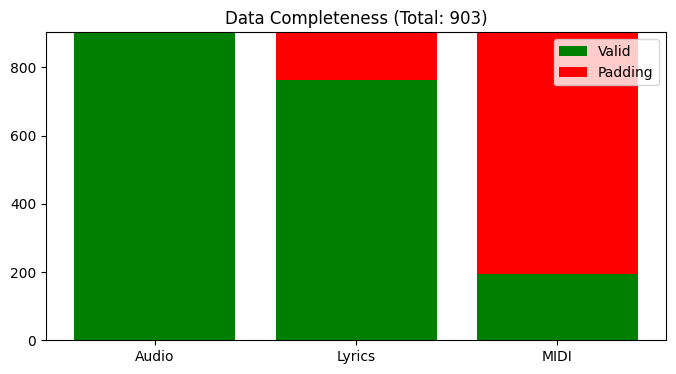

Dimensi Input: Audio=2048, Lirik=768, MIDI=768


In [4]:
# ==========================================
# 3. ALIGNMENT (PENYELARASAN DATA)
# ==========================================
def align_data_union(data_container):
    print("\n=== MENJALANKAN ALIGNMENT (UNION STRATEGY) ===")

    # Identifikasi ID Unik
    ids_audio = set([str(k).replace('.mp3', '') for k in data_container['audio'].keys()])
    ids_lyrics = set(data_container['lyrics']['song_id'].astype(str).values) if not data_container['lyrics'].empty else set()
    ids_midi = set(data_container['midi']['song_id'].astype(str).values) if not data_container['midi'].empty else set()

    all_ids = sorted(list(ids_audio | ids_lyrics | ids_midi))

    if not all_ids:
        raise ValueError("Tidak ada ID lagu yang ditemukan. Cek path dataset Anda.")

    # Persiapan Dimensi untuk Zero Padding
    dim_aud = next(iter(data_container['audio'].values())).shape[0] if ids_audio else 0
    dim_lyr = data_container['lyrics']['bert_features'].iloc[0].shape[0] if not data_container['lyrics'].empty else 0
    dim_mid = data_container['midi']['midi_features'].iloc[0].shape[0] if not data_container['midi'].empty else 0

    # Helper Map
    lyric_map = dict(zip(data_container['lyrics']['song_id'].astype(str), data_container['lyrics']['bert_features'])) if not data_container['lyrics'].empty else {}
    midi_map = dict(zip(data_container['midi']['song_id'].astype(str), data_container['midi']['midi_features'])) if not data_container['midi'].empty else {}

    aligned = {'audio': [], 'lyrics': [], 'midi': []}
    masks = {'audio': [], 'lyrics': [], 'midi': []}

    for sid in all_ids:
        # Audio
        key = f"{sid}.mp3" if f"{sid}.mp3" in data_container['audio'] else sid
        if key in data_container['audio']:
            aligned['audio'].append(data_container['audio'][key])
            masks['audio'].append(1)
        else:
            aligned['audio'].append(np.zeros(dim_aud))
            masks['audio'].append(0)

        # Lyrics
        if sid in lyric_map:
            aligned['lyrics'].append(lyric_map[sid])
            masks['lyrics'].append(1)
        else:
            aligned['lyrics'].append(np.zeros(dim_lyr))
            masks['lyrics'].append(0)

        # MIDI
        if sid in midi_map:
            aligned['midi'].append(midi_map[sid])
            masks['midi'].append(1)
        else:
            aligned['midi'].append(np.zeros(dim_mid))
            masks['midi'].append(0)

    # Convert ke Tensor
    tensors = {}
    mask_tensors = {}

    # Cek agar tidak error saat stack empty array
    if len(aligned['audio']) > 0:
        tensors = {k: torch.tensor(np.stack(v), dtype=torch.float32) for k, v in aligned.items()}
        mask_tensors = {k: torch.tensor(v, dtype=torch.float32) for k, v in masks.items()}
    else:
        print(" Warning: Data aligned kosong.")

    return tensors, mask_tensors, all_ids

# Eksekusi Alignment
inputs, masks, song_ids = align_data_union(raw_data)

# Visualisasi Sederhana
if len(song_ids) > 0:
    modalities = ['Audio', 'Lyrics', 'MIDI']
    valid_counts = [masks['audio'].sum().item(), masks['lyrics'].sum().item(), masks['midi'].sum().item()]
    total_samples = len(song_ids)
    missing_counts = [total_samples - x for x in valid_counts]

    plt.figure(figsize=(8, 4))
    plt.bar(modalities, valid_counts, label='Valid', color='green')
    plt.bar(modalities, missing_counts, bottom=valid_counts, label='Padding', color='red')
    plt.title(f'Data Completeness (Total: {total_samples})')
    plt.legend()
    plt.show()

    print(f"Dimensi Input: Audio={inputs['audio'].shape[1]}, Lirik={inputs['lyrics'].shape[1]}, MIDI={inputs['midi'].shape[1]}")




In [5]:
# ==========================================
# 5. FUSION MODEL PREPARATION
# ==========================================
print("\n=== PERSIAPAN FUSION ===")

def get_labels_aligned(dataset_path, sorted_song_ids):
    print("Mengambil label dari file .bat...")
    label_map = {}
    bat_files = [
        os.path.join(dataset_path, 'split-by-categories-audio.bat'),
        os.path.join(dataset_path, 'split-by-categories-lyrics.bat'),
        os.path.join(dataset_path, 'split-by-categories-midi.bat'),
    ]

    for b_file in bat_files:
        if os.path.exists(b_file):
            with open(b_file, 'r', encoding='utf-8', errors='ignore') as f:
                for line in f:
                    # Regex untuk parsing file bat (move filename "path/Cluster X")
                    m = re.search(r'move\s+([^\s]+)\s+"?([^"]+)"?', line, flags=re.IGNORECASE)
                    if m:
                        fname = os.path.basename(m.group(1))
                        sid = os.path.splitext(fname)[0]
                        dest = m.group(2)
                        c_match = re.search(r'Cluster\s*(\d+)', dest, flags=re.IGNORECASE)
                        if c_match:
                            label_map[sid] = int(c_match.group(1)) - 1
        else:
            print(f"Warning: File bat tidak ditemukan: {b_file}")

    aligned_labels = []
    valid_indices = []

    for idx, sid in enumerate(sorted_song_ids):
        sid_str = str(int(sid)) if str(sid).isdigit() else str(sid)
        if sid in label_map:
            aligned_labels.append(label_map[sid])
            valid_indices.append(idx)
        elif sid_str in label_map:
            aligned_labels.append(label_map[sid_str])
            valid_indices.append(idx)

    return np.array(aligned_labels), valid_indices

# Load Labels
if len(song_ids) > 0:
    y_all, valid_idx = get_labels_aligned(DATASET_DIR, song_ids)

    if len(y_all) > 0:
        # Filter Embedding
        X_audio = embeddings['audio'][valid_idx]
        X_lyrics = embeddings['lyrics'][valid_idx]
        X_midi = embeddings['midi'][valid_idx]

        # Filter Mask
        M_audio = masks['audio'][valid_idx]
        M_lyrics = masks['lyrics'][valid_idx]
        M_midi = masks['midi'][valid_idx]

        print(f"Data siap untuk Fusion: {len(y_all)} sampel.")
    else:
        print("Tidak ada label yang ditemukan. Pastikan file .bat ada dan sesuai format.")
        X_audio = None # Stop process flag





=== PERSIAPAN FUSION ===
Mengambil label dari file .bat...
Data siap untuk Fusion: 903 sampel.


In [6]:
# ==========================================
# 6. DATASET & MODEL FUSION (OPTIMIZED)
# ==========================================
if 'X_audio' in locals() and X_audio is not None:

    # Split Dataset (Train=70%, Val=15%, Test=15%)
    indices = np.arange(len(y_all))
    try:
        # First split: Train (70%) vs Temp (30%)
        train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42, stratify=y_all)
        # Second split: Val (50% of 30% -> 15%) vs Test (50% of 30% -> 15%)
        y_temp = y_all[temp_idx]
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42, stratify=y_temp)
    except ValueError as e:
        print(f"Split error (data insufficient for stratify): {e}")
        train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
        val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

    print(f"Train: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    class MultimodalDataset(Dataset):
        def __init__(self, idxs, aud, lyr, mid, ma, ml, mm, labels):
            self.idxs = idxs
            self.aud = aud
            self.lyr = lyr
            self.mid = mid
            self.ma = ma
            self.ml = ml
            self.mm = mm
            self.labels = torch.tensor(labels, dtype=torch.long)

        def __len__(self):
            return len(self.idxs)

        def __getitem__(self, i):
            idx = self.idxs[i]
            return (
                self.aud[idx], self.lyr[idx], self.mid[idx],
                self.ma[idx], self.ml[idx], self.mm[idx],
                self.labels[idx]
            )

    train_dataset = MultimodalDataset(train_idx, X_audio, X_lyrics, X_midi, M_audio, M_lyrics, M_midi, y_all)
    val_dataset = MultimodalDataset(val_idx, X_audio, X_lyrics, X_midi, M_audio, M_lyrics, M_midi, y_all)
    test_dataset = MultimodalDataset(test_idx, X_audio, X_lyrics, X_midi, M_audio, M_lyrics, M_midi, y_all)

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

    # --- ADVANCED ARCHITECTURE COMPONENTS ---

    class GatedMultimodalUnit(nn.Module):
        def __init__(self, input_dim):
            super(GatedMultimodalUnit, self).__init__()
            self.fc_h = nn.Linear(input_dim, input_dim)
            self.fc_z = nn.Linear(input_dim, input_dim)

        def forward(self, x):
            h = torch.tanh(self.fc_h(x))
            z = torch.sigmoid(self.fc_z(x))
            return z * h + (1 - z) * x

    class MultiHeadAttention(nn.Module):
        def __init__(self, input_dim, num_heads):
            super(MultiHeadAttention, self).__init__()
            self.mha = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, batch_first=True)

        def forward(self, kv, q, key_padding_mask=None):
            # q: (Batch, 1, Dim) -> query (fused context)
            # kv: (Batch, Seq, Dim) -> key/value (modalities)
            attn_output, attn_weights = self.mha(q, kv, kv, key_padding_mask=key_padding_mask)
            return attn_output, attn_weights

    class AdvancedFusion(nn.Module):
        def __init__(self, input_dim, num_classes=5, num_heads=4, dropout=0.3):
            super(AdvancedFusion, self).__init__()
            
            # 1. Modality Weights (Simple Attention mechanism first to get Query)
            self.attn_fc = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

            # 2. Multi-Head Attention
            self.mha = MultiHeadAttention(input_dim, num_heads)
            
            # 3. Gated Multimodal Unit
            self.gmu = GatedMultimodalUnit(input_dim)

            # 4. Residual MLP Classifier
            self.classifier = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(256, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(128, num_classes)
            )
            
            self.residual_fc = nn.Linear(input_dim, 128)

        def forward(self, a, l, m, ma, ml, mm):
            # Stack modalities: (Batch, 3, Dim)
            stacked = torch.stack([a, l, m], dim=1)
            
            # Masks: (Batch, 3)
            masks_stack = torch.stack([ma, ml, mm], dim=1)
            # MHA mask: True means ignore position
            key_padding_mask = (masks_stack == 0)

            # Initial Attention to get a weighted sum (Query)
            scores = self.attn_fc(stacked)
            scores = scores.masked_fill(masks_stack.unsqueeze(-1) == 0, -1e9)
            weights = torch.softmax(scores, dim=1)
            initial_fused = torch.sum(stacked * weights, dim=1).unsqueeze(1)

            # Multi-Head Attention
            mha_out, _ = self.mha(stacked, initial_fused, key_padding_mask=key_padding_mask)
            mha_out = mha_out.squeeze(1)

            # GMU Gating
            gmu_out = self.gmu(mha_out)

            # Classifier with Residual
            x = self.classifier[0](gmu_out)
            x = self.classifier[1](x)
            x = self.classifier[2](x)
            x = self.classifier[3](x)
            x = self.classifier[4](x)
            
            # Residual connection
            res = self.residual_fc(gmu_out)
            x = x + res
            
            x = self.classifier[5](x)
            x = self.classifier[6](x)
            x = self.classifier[7](x)
            logits = self.classifier[8](x)
            
            return logits

Train: 632, Val: 135, Test: 136



=== MEMULAI TRAINING (cpu) ===
Epoch 1/100
Train | Loss: 1.5033 | Acc: 35.44% | F1-Mac: 0.3326
Val   | Loss: 1.3990   | Acc: 39.26%   | F1-Mac: 0.3166
Epoch 2/100
Train | Loss: 1.2837 | Acc: 45.41% | F1-Mac: 0.4247
Val   | Loss: 1.2763   | Acc: 51.11%   | F1-Mac: 0.4820
Epoch 3/100
Train | Loss: 1.1915 | Acc: 52.85% | F1-Mac: 0.5176
Val   | Loss: 1.3528   | Acc: 48.15%   | F1-Mac: 0.4626
Epoch 4/100
Train | Loss: 1.0768 | Acc: 56.96% | F1-Mac: 0.5535
Val   | Loss: 1.2388   | Acc: 51.11%   | F1-Mac: 0.4920
Epoch 5/100
Train | Loss: 0.9836 | Acc: 62.50% | F1-Mac: 0.6202
Val   | Loss: 1.5309   | Acc: 48.15%   | F1-Mac: 0.4119
Epoch 6/100
Train | Loss: 0.9674 | Acc: 63.13% | F1-Mac: 0.6221
Val   | Loss: 1.3611   | Acc: 51.85%   | F1-Mac: 0.5103
Epoch 7/100
Train | Loss: 0.9526 | Acc: 62.97% | F1-Mac: 0.6178
Val   | Loss: 1.4430   | Acc: 44.44%   | F1-Mac: 0.4335
Epoch 8/100
Train | Loss: 0.8729 | Acc: 65.35% | F1-Mac: 0.6516
Val   | Loss: 1.3988   | Acc: 48.89%   | F1-Mac: 0.4907
Epoch 9/

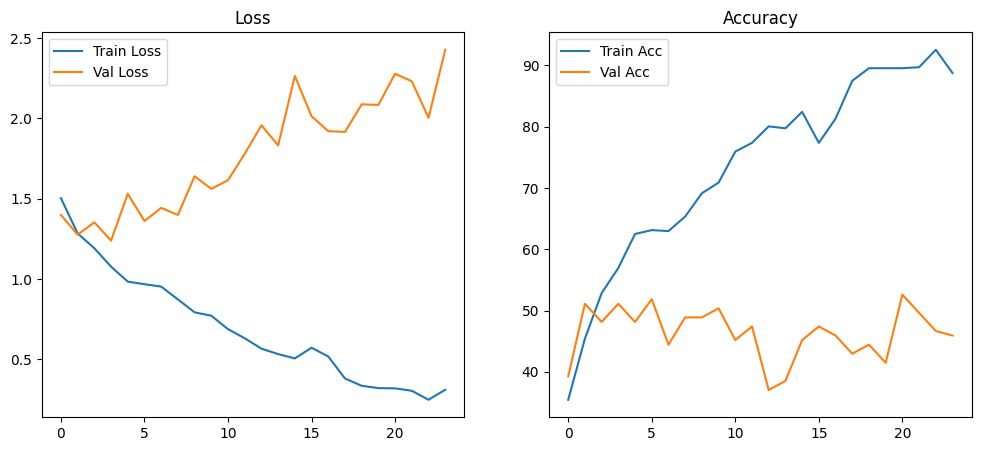


=== EVALUASI TEST SET ===
Test Accuracy: 40.44%

Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.15      0.22        26
           1       0.28      0.21      0.24        24
           2       0.43      0.67      0.52        33
           3       0.41      0.38      0.39        29
           4       0.45      0.54      0.49        24

    accuracy                           0.40       136
   macro avg       0.39      0.39      0.37       136
weighted avg       0.39      0.40      0.38       136


Confusion Matrix:


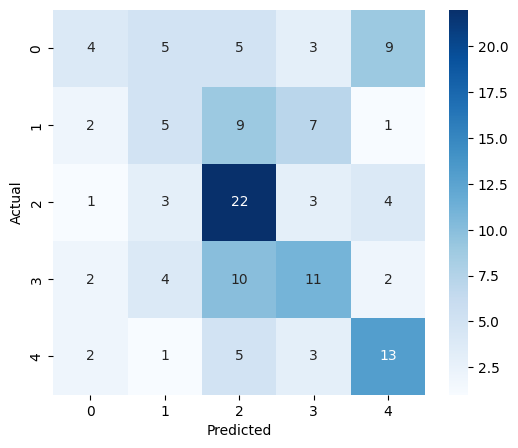

In [7]:
# ==========================================
# 7. TRAINING LOOP WITH EARLY STOPPING & METRICS
# ==========================================
class EarlyStopping:
    def __init__(self, patience=20, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    return acc, f1_macro, f1_weighted

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdvancedFusion(
    input_dim=CONFIG['target_dim'], 
    num_classes=5, 
    num_heads=CONFIG['num_heads'], 
    dropout=CONFIG['dropout']
).to(device)

optimizer = optim.Adam(model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=CONFIG['patience'])

print(f"\n=== MEMULAI TRAINING ({device}) ===")
EPOCHS = CONFIG['epochs']

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # --- TRAIN ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    y_true_train, y_pred_train = [], []
    
    for batch in train_loader:
        aud, lyr, mid, ma, ml, mm, labels = [b.to(device) for b in batch]
        
        optimizer.zero_grad()
        outputs = model(aud, lyr, mid, ma, ml, mm)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        y_true_train.extend(labels.cpu().numpy())
        y_pred_train.extend(predicted.cpu().numpy())

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = 100 * train_correct / train_total
    
    # --- VALIDATION ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    y_true_val, y_pred_val = [], []
    
    with torch.no_grad():
        for batch in val_loader:
            aud, lyr, mid, ma, ml, mm, labels = [b.to(device) for b in batch]
            outputs = model(aud, lyr, mid, ma, ml, mm)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(predicted.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = 100 * val_correct / val_total
    
    # Metrics
    _, train_f1_m, train_f1_w = calculate_metrics(y_true_train, y_pred_train)
    _, val_f1_m, val_f1_w = calculate_metrics(y_true_val, y_pred_val)

    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"Train | Loss: {avg_train_loss:.4f} | Acc: {avg_train_acc:.2f}% | F1-Mac: {train_f1_m:.4f}")
    print(f"Val   | Loss: {avg_val_loss:.4f}   | Acc: {avg_val_acc:.2f}%   | F1-Mac: {val_f1_m:.4f}")
    
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

# --- PLOTTING ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()

# --- EVALUATION ON TEST SET ---
print("\n=== EVALUASI TEST SET ===")
model.eval()
test_correct, test_total = 0, 0
y_true_test, y_pred_test = [], []

with torch.no_grad():
    for batch in test_loader:
        aud, lyr, mid, ma, ml, mm, labels = [b.to(device) for b in batch]
        outputs = model(aud, lyr, mid, ma, ml, mm)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        y_true_test.extend(labels.cpu().numpy())
        y_pred_test.extend(predicted.cpu().numpy())

test_acc = 100 * test_correct / test_total
print(f"Test Accuracy: {test_acc:.2f}%")
print("\nClassification Report:")
print(classification_report(y_true_test, y_pred_test))

print("\nConfusion Matrix:")
try:
    cm = confusion_matrix(y_true_test, y_pred_test)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
except Exception as e:
    print(f"Error plotting CM: {e}")


In [8]:
# ==========================================
# 8. EVALUASI
# ==========================================
print("\n=== HASIL EVALUASI TEST SET ===")
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        aud, lyr, mid, ma, ml, mm, labels = [b.to(device) for b in batch]
        outputs = model(aud, lyr, mid, ma, ml, mm)
        _, predicted = torch.max(outputs.data, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(f"Test Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=[f'Cluster {i+1}' for i in range(5)]))

# Save Model
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'fusion_model.pth'))
print(f"\nModel tersimpan di: {os.path.join(OUTPUT_DIR, 'fusion_model.pth')}")


=== HASIL EVALUASI TEST SET ===
Test Accuracy: 0.4044

Classification Report:
              precision    recall  f1-score   support

   Cluster 1       0.36      0.15      0.22        26
   Cluster 2       0.28      0.21      0.24        24
   Cluster 3       0.43      0.67      0.52        33
   Cluster 4       0.41      0.38      0.39        29
   Cluster 5       0.45      0.54      0.49        24

    accuracy                           0.40       136
   macro avg       0.39      0.39      0.37       136
weighted avg       0.39      0.40      0.38       136


Model tersimpan di: d:\Multimodal\Multi_modality_music\ready_for_fusion\fusion_model.pth
